This code runs FedADMM on synthetic dataset, This code is developed on FedPD code to incorporate FedADMM 
changes(https://github.com/564612540/FedPD), The synthetic dataset used is created based on the code from 
https://github.com/litian96/FedProx/tree/master/data

In [23]:
from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from pathlib import Path

# Change this to where you put your hw1 files
DATA = Path("/content/drive/MyDrive/columbia_spring_2022/Research/federated")

In [25]:
import os
import copy
import time
import pickle
import json
import numpy as np
from tqdm import tqdm
import pdb

import torch
from torch import nn

torch.manual_seed(0)

In [26]:
os.chdir(DATA / 'src')
from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar, CNNFEMnist
from utils import get_dataset, average_weights, exp_details
from agent import Agent

In [27]:
class arg:
  def __init__(self):
    self.epochs = 200 #number of global rounds 
    self.freq_in = 300 #number of inner loops
    self.freq_out = 1 
    self.num_users = 30 # Total number of users
    self.partial_users = 10 # number of partial users
    self.local_ep = 300
    self.local_bs = 2
    self.lr = 0.01
    self.mu = 1
    #self.dataset = 'femnist'
    self.VR = False
    self.model = 'mlp' 
    self.optimizer = 'FedPD' 
    self.gpu = False
args = arg()

In [28]:
os.chdir('..')

In [29]:
#choose which synthetic dataset to run
train_path = os.path.join('data', 'synthetic_1_1', 'data', 'train')
test_path = os.path.join('data', 'synthetic_1_1', 'data', 'test')

In [30]:
clients = []
groups = []
train_data = {}
test_data = {}

train_files = os.listdir(train_path)
train_files = [f for f in train_files if f.endswith('.json')]
for f in train_files:
    file_path = os.path.join(train_path,f)
    with open(file_path, 'r') as inf:
        cdata = json.load(inf)
    clients.extend(cdata['users'])
    if 'hierarchies' in cdata:
        groups.extend(cdata['hierarchies'])
    train_data.update(cdata['user_data'])

test_files = os.listdir(test_path)
test_files = [f for f in test_files if f.endswith('.json')]
for f in test_files:
    file_path = os.path.join(test_path,f)
    with open(file_path, 'r') as inf:
        cdata = json.load(inf)
    test_data.update(cdata['user_data'])

clients = list(sorted(train_data.keys()))

In [31]:
user_groups = {i:len(train_data[key]['x']) for i,key in enumerate(train_data.keys())}
temp = 0
for i in user_groups.keys():
  user_groups[i] = np.arange(temp,user_groups[i]+temp)
  temp += len(user_groups[i])

In [32]:
import torch
from torch.utils.data import DataLoader, Dataset
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image,dtype=torch.float32), torch.tensor(label)

In [33]:
dict_users = {i: np.array([]) for i in range(30)} # number of users
train_size = 0
test_size = 0
train_data_new = []
test_data_new = []

for user in clients:
    train_data_new.extend([[np.array(x,dtype=np.float),np.array(y,dtype=np.int64)] for x,y in zip(train_data[user]['x'],train_data[user]['y'])])
    test_data_new.extend([[np.array(x,dtype=np.float),np.array(y,dtype=np.int64)] for x,y in zip(test_data[user]['x'],test_data[user]['y'])])

idxs_train = np.arange(sum(len(train_data[key]['x']) for i,key in enumerate(train_data.keys())))
train_data = DatasetSplit(train_data_new, idxs_train)
idxs_test = np.arange(sum(len(test_data[key]['x']) for i,key in enumerate(test_data.keys())))
test_data = DatasetSplit(test_data_new, idxs_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [34]:
global_model = MLP(60,32,10)
global_model.train()

MLP(
  (layer_input): Linear(in_features=60, out_features=32, bias=True)
  (relu): ReLU()
  (layer_hidden1): Linear(in_features=32, out_features=32, bias=True)
  (layer_hidden): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [35]:
if args.gpu:
        torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

In [36]:
agent_list = []
for i in range(args.num_users):
    agent_list.append(Agent(global_model,args,i, nn.NLLLoss().to(device)))

# copy weights
global_weights = global_model.state_dict()

In [37]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 5
val_loss_pre, counter = 0, 0

In [38]:
def aa_weights(Y, g, reg = 0, type = "lstsq", *args, **kwargs):
	if type == "lstsq":
		if reg != 0:
			m = Y.shape[1]
			Y = np.vstack([Y, np.sqrt(reg)*np.eye(m)])
			g = np.concatenate([g, np.zeros(m)])
		gamma = np.linalg.lstsq(Y, g, *args, **kwargs)[0]
	elif type == "lsqr":
		if reg != 0:
			m = Y.shape[1]
			Y = sp.csc_matrix(Y)
			Y = sp.vstack([Y, np.sqrt(reg)*sp.eye(m)])
			g = np.concatenate([g, np.zeros(m)])
		gamma = sp.linalg.lsqr(Y, g, *args, **kwargs)[0]
	else:
		raise ValueError("Algorithm type not supported:", type)
	gamma_diff = np.diff(gamma, n=1)
	alpha = np.concatenate(([gamma[0]], gamma_diff, [1-gamma[-1]]))
	return alpha

In [ ]:
import random
random.seed(10)
global_dict = {}
m_max = 3
D_safe = 1 #1e6
eps_safe = 1e-6
M_safe = 2
safeguard = True
for epoch in tqdm(range(args.epochs)):
  local_weights = []
  print(f'\n | Global Training Round : {epoch+1} |\n')

  m = args.num_users
  if epoch % args.freq_out ==0:
      compute_full = True
      update_model = True
  else:
      compute_full = False
      update_model = False
  global_model.train()

  #keep a copy of all the local state dictionaries globally
  if epoch == 0:
    for idx in range(args.num_users):
      global_dict[str(idx)] = global_model.state_dict()

  # randomly choose which users to use for global update
  S = [str(i) for i in random.sample(range(args.num_users),args.partial_users)]

  # run the clients that are selected
  for idx in S:
      w= agent_list[int(idx)].train_(global_model.state_dict(), args.freq_in, train_data, user_groups, update_model, compute_full)
      # print(w['layer3.0.bias'])
      local_weights.append(copy.deepcopy(w))
      global_dict[idx] = local_weights[-1]
  # for idx in range(args.num_users):
  #     print(local_weights[idx]['layer3.0.bias'])


  if S:
      w_avg = copy.deepcopy(local_weights[0])
      w_avg = {key: w_avg[key]-w_avg[key] for key in w_avg.keys()}
      for key in w_avg.keys():
          for i in range(args.num_users):
              w_avg[key].add_(global_dict[str(i)][key])
          w_avg[key].div_(args.num_users)
      # print(w_avg['layer3.0.bias'])

      ##########################################################################
      # Anderson Acceleration
      ##########################################################################
      # if k=0, then make initializations and skip anderson acceleration
      if epoch == 0:
        # record parameters of the neural network
        all_keys = [key for key in w_avg.keys()]
        sizes = [np.prod(w_avg[key].shape) for key in all_keys]
        shapes = [w_avg[key].shape for key in all_keys]
        # get v_k which in this case is the initial random weights
        vk = []
        [vk.extend(global_model.get_parameter(key).detach().numpy().flatten()) for key in all_keys]
        vk = np.array(vk)
        # get v_{k+1, ADMM}
        vk1 = []
        [vk1.extend(w_avg[key].numpy().flatten()) for key in all_keys]
        vk1 = np.array(vk1)
        """
        Construct 3 arrays:
          - The array of weights (v_hist) which will contain m_max+1 elements when enough epochs are run
          - Two arrays (y_hist, s_hist) which will contain m_max elements when enough epochs are run
            which are used calculate the optimization problem and obtain the alphas
        """
        v_hist = [vk1]
        y_hist = []
        s_hist = []
        # calculate the norm of the initial residual for safeguarding  
        g_vec = vk-vk1
        g0_norm = np.linalg.norm(g_vec)
        # additional counter initializations for safeguarding
        n_AA = M_AA = 0

        vk_old = vk.copy()
        vk = vk1.copy()

      else:
        # get v_{k+1, ADMM} which is simply the calculated average
        vk1 = []
        [vk1.extend(w_avg[key].numpy().flatten()) for key in all_keys]

        # append to vhist which is the history of the weights
        v_hist.append(vk1)
        if len(v_hist) > m_max+1:
          v_hist.pop(0)     

        # compute g_k = v_k - v_{k+1, ADMM}
        g_new = vk - vk1

        # append to y_hist as y_{k-1} = g_k - g_{k-1}
        y_hist.append(g_new - g_vec)
        if len(y_hist) > m_max:
          y_hist.pop(0)
        g_vec = g_new

        # append to s_hist as s_{k-1} = v_k - v[k-1]
        s_hist.append(vk - vk_old)
        if len(s_hist) > m_max:
          s_hist.pop(0)

        # calculate ymat and smat
        Y_mat = np.column_stack(y_hist)
        S_mat = np.column_stack(s_hist)

        # calcualte alphas with regularization
        reg = 1e-8 * np.linalg.norm(Y_mat)**2 + np.linalg.norm(S_mat)**2
        alphas = aa_weights(Y_mat, g_new, reg = reg, type = "lstsq")
        print(alphas)

        # perform safeguard check
        if safeguard or M_AA >= M_safe:
          if np.linalg.norm(g_vec) <= D_safe*g0_norm*(n_AA/M_safe + 1)**(-(1 + eps_safe)):
            n_AA = n_AA + 1
            M_AA = 1
            safeguard = False
            AA_update = True
          else:
            print('safeguard activated')
            M_AA = 0
            safeguard = True
            AA_update = False
        else:
          AA_update = True
          M_AA = M_AA + 1
          n_AA = n_AA + 1
        
        if AA_update:
          v_new = alphas.dot(v_hist)
          for i in range(len(all_keys)):
            st = int(np.sum(sizes[:i]))
            end = int(np.sum(sizes[:i+1]))
            w_avg[all_keys[i]] = torch.Tensor(v_new[st:end].reshape(shapes[i]))
          vk = v_new

        else:
          v_new = np.array(vk1)
          vk = v_new.copy()
          
        vk_old = vk.copy()

      ##########################################################################
      # End of Anderson Acceleration
      ##########################################################################

      # update global weights
      global_weights = w_avg

      # update global weights
      global_model.load_state_dict(global_weights)


  # print(global_model)

  # Calculate avg training accuracy over all users at every epoch
  global_model.eval()
  test_acc, test_loss = test_inference(args, global_model, test_data)
  train_accuracy.append(test_acc)
  train_loss.append(test_loss)

  # print global training loss after every 'i' rounds
  if (epoch+1) % print_every == 0:
      print(f' \nAvg Training Stats after {epoch+1} global rounds:')
      print(f'Training Loss : {np.mean(np.array(train_loss))}')
      print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]),flush=True)

  0%|          | 0/200 [00:00<?, ?it/s]/content/drive/MyDrive/columbia_spring_2022/Research/federated/src/agent.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image,dtype=torch.float32), torch.tensor(label)



 | Global Training Round : 1 |



  0%|          | 1/200 [00:02<08:27,  2.55s/it]


 | Global Training Round : 2 |



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys
  1%|          | 2/200 [00:04<07:59,  2.42s/it]

[0.37990127 0.62009873]
safeguard activated

 | Global Training Round : 3 |



  2%|▏         | 3/200 [00:07<07:45,  2.36s/it]

[ 0.23148726 -0.3342841   1.10279683]

 | Global Training Round : 4 |



  2%|▏         | 4/200 [00:09<07:39,  2.34s/it]

[ 0.1770625  -0.27470214  0.0594645   1.03817514]

 | Global Training Round : 5 |

[-0.29887633  0.00937206  0.61893281  0.67057146]
safeguard activated
 
Avg Training Stats after 5 global rounds:
Training Loss : 13.910417878627777
Train Accuracy: 36.72% 



  2%|▎         | 5/200 [00:11<07:40,  2.36s/it]


 | Global Training Round : 6 |



  3%|▎         | 6/200 [00:14<07:38,  2.36s/it]

[-0.15166002  0.123442    0.2169883   0.81122972]

 | Global Training Round : 7 |



  4%|▎         | 7/200 [00:16<07:32,  2.35s/it]

[-0.03640228  0.16805361  0.57476128  0.29358739]

 | Global Training Round : 8 |



  4%|▍         | 8/200 [00:18<07:29,  2.34s/it]

[ 0.16820304  0.56637098  0.3381498  -0.07272382]
safeguard activated

 | Global Training Round : 9 |



  4%|▍         | 9/200 [00:21<07:26,  2.34s/it]

[ 0.53523347  0.27222737 -0.04700524  0.23954441]
safeguard activated

 | Global Training Round : 10 |

[0.31688314 0.06379699 0.28837189 0.33094797]
safeguard activated
 
Avg Training Stats after 10 global rounds:
Training Loss : 12.752511477470398
Train Accuracy: 41.70% 



  5%|▌         | 10/200 [00:23<07:23,  2.33s/it]


 | Global Training Round : 11 |



  6%|▌         | 11/200 [00:25<07:23,  2.34s/it]

[0.20588933 0.21912749 0.27717474 0.29780844]
safeguard activated

 | Global Training Round : 12 |



  6%|▌         | 12/200 [00:28<07:23,  2.36s/it]

[0.21676333 0.20633077 0.26956609 0.3073398 ]
safeguard activated

 | Global Training Round : 13 |



  6%|▋         | 13/200 [00:30<07:21,  2.36s/it]

[0.15603649 0.26547854 0.3006023  0.27788267]
safeguard activated

 | Global Training Round : 14 |



  7%|▋         | 14/200 [00:33<07:20,  2.37s/it]

[0.282387   0.15118931 0.08696896 0.47945473]
safeguard activated

 | Global Training Round : 15 |

[0.24970702 0.147603   0.35353069 0.24915929]
safeguard activated
 
Avg Training Stats after 15 global rounds:
Training Loss : 12.068911174933115
Train Accuracy: 44.65% 



  8%|▊         | 15/200 [00:35<07:32,  2.44s/it]


 | Global Training Round : 16 |



  8%|▊         | 16/200 [00:39<08:45,  2.86s/it]

[0.11085993 0.43635124 0.11661719 0.33617164]
safeguard activated

 | Global Training Round : 17 |



  8%|▊         | 17/200 [00:43<10:08,  3.33s/it]

[0.43703825 0.10744245 0.32572968 0.12978961]
safeguard activated

 | Global Training Round : 18 |



  9%|▉         | 18/200 [00:46<09:10,  3.02s/it]

[0.20797111 0.26556705 0.24577003 0.28069181]
safeguard activated

 | Global Training Round : 19 |



 10%|▉         | 19/200 [00:48<08:46,  2.91s/it]

[0.25904216 0.17422665 0.22534246 0.34138873]
safeguard activated

 | Global Training Round : 20 |

[0.19261354 0.24487456 0.29416094 0.26835095]
safeguard activated
 
Avg Training Stats after 20 global rounds:
Training Loss : 11.603831389546395
Train Accuracy: 42.71% 



 10%|█         | 20/200 [00:52<09:47,  3.26s/it]


 | Global Training Round : 21 |



 10%|█         | 21/200 [00:55<08:53,  2.98s/it]

[0.26507649 0.33118578 0.24631298 0.15742475]
safeguard activated

 | Global Training Round : 22 |



 11%|█         | 22/200 [00:57<08:11,  2.76s/it]

[0.47040893 0.13679416 0.17113201 0.2216649 ]
safeguard activated

 | Global Training Round : 23 |



 12%|█▏        | 23/200 [00:59<07:45,  2.63s/it]

[0.34439876 0.12885901 0.13773111 0.38901112]
safeguard activated

 | Global Training Round : 24 |



 12%|█▏        | 24/200 [01:02<07:27,  2.54s/it]

[0.23147498 0.19270711 0.24425034 0.33156757]
safeguard activated

 | Global Training Round : 25 |

[0.16104746 0.36708834 0.25487182 0.21699238]
safeguard activated
 
Avg Training Stats after 25 global rounds:
Training Loss : 11.26174265384674
Train Accuracy: 44.28% 



 12%|█▎        | 25/200 [01:04<07:27,  2.56s/it]


 | Global Training Round : 26 |



 13%|█▎        | 26/200 [01:07<07:11,  2.48s/it]

[0.2169489  0.10088338 0.36916585 0.31300187]
safeguard activated

 | Global Training Round : 27 |



 14%|█▎        | 27/200 [01:09<06:58,  2.42s/it]

[0.00359436 0.42973504 0.24748605 0.31918455]
safeguard activated

 | Global Training Round : 28 |



 14%|█▍        | 28/200 [01:12<07:37,  2.66s/it]

[0.3656105  0.22070801 0.23623954 0.17744195]
safeguard activated

 | Global Training Round : 29 |



 14%|█▍        | 29/200 [01:15<08:04,  2.83s/it]

[0.18056535 0.25018408 0.21143209 0.35781848]
safeguard activated

 | Global Training Round : 30 |

[0.20135727 0.16601507 0.21770002 0.41492764]
 
Avg Training Stats after 30 global rounds:
Training Loss : 10.975472605228424
Train Accuracy: 47.05% 



 15%|█▌        | 30/200 [01:19<08:26,  2.98s/it]


 | Global Training Round : 31 |



 16%|█▌        | 31/200 [01:21<08:03,  2.86s/it]

[ 0.31376276  0.24594995  0.583782   -0.14349471]

 | Global Training Round : 32 |



 16%|█▌        | 32/200 [01:24<07:33,  2.70s/it]

[ 0.33924828  0.59770296 -0.17393652  0.23698529]
safeguard activated

 | Global Training Round : 33 |



 16%|█▋        | 33/200 [01:26<07:10,  2.58s/it]

[ 0.61720191 -0.07546222  0.13486888  0.32339143]
safeguard activated

 | Global Training Round : 34 |



 17%|█▋        | 34/200 [01:28<07:00,  2.53s/it]

[0.25061654 0.098518   0.31505002 0.33581544]
safeguard activated

 | Global Training Round : 35 |

[0.1269738  0.20718292 0.27551488 0.39032839]
safeguard activated
 
Avg Training Stats after 35 global rounds:
Training Loss : 10.763237195355552
Train Accuracy: 46.13% 



 18%|█▊        | 35/200 [01:31<06:49,  2.48s/it]


 | Global Training Round : 36 |



 18%|█▊        | 36/200 [01:33<06:49,  2.50s/it]

[0.24835382 0.17764198 0.31861124 0.25539296]
safeguard activated

 | Global Training Round : 37 |



 18%|█▊        | 37/200 [01:36<06:39,  2.45s/it]

[0.12633965 0.39350463 0.20184317 0.27831255]
safeguard activated

 | Global Training Round : 38 |



 19%|█▉        | 38/200 [01:38<06:29,  2.41s/it]

[0.35786783 0.14473654 0.25178294 0.24561269]
safeguard activated

 | Global Training Round : 39 |



 20%|█▉        | 39/200 [01:40<06:23,  2.38s/it]

[0.15516771 0.26434728 0.23739997 0.34308504]
safeguard activated

 | Global Training Round : 40 |

[0.21401812 0.27173109 0.32730349 0.18694729]
safeguard activated
 
Avg Training Stats after 40 global rounds:
Training Loss : 10.569850371778012
Train Accuracy: 51.11% 



 20%|██        | 40/200 [01:42<06:17,  2.36s/it]


 | Global Training Round : 41 |



 20%|██        | 41/200 [01:45<06:15,  2.36s/it]

[0.24107305 0.29438188 0.16047338 0.30407169]
safeguard activated

 | Global Training Round : 42 |



 21%|██        | 42/200 [01:47<06:11,  2.35s/it]

[0.33115176 0.1574675  0.22826969 0.28311105]
safeguard activated

 | Global Training Round : 43 |



 22%|██▏       | 43/200 [01:49<06:05,  2.32s/it]

[0.20942053 0.22476155 0.29944275 0.26637516]
safeguard activated

 | Global Training Round : 44 |



 22%|██▏       | 44/200 [01:52<06:02,  2.32s/it]

[0.2477574  0.25849001 0.18215335 0.31159924]
safeguard activated

 | Global Training Round : 45 |

[0.28288317 0.18678193 0.31284186 0.21749305]
safeguard activated
 
Avg Training Stats after 45 global rounds:
Training Loss : 10.406326723098754
Train Accuracy: 47.51% 



 22%|██▎       | 45/200 [01:54<05:59,  2.32s/it]


 | Global Training Round : 46 |



 23%|██▎       | 46/200 [01:56<05:56,  2.31s/it]

[0.16630611 0.32618974 0.29236607 0.21513808]
safeguard activated

 | Global Training Round : 47 |



 24%|██▎       | 47/200 [01:59<05:53,  2.31s/it]

[0.38169881 0.26023372 0.18792019 0.17014728]
safeguard activated

 | Global Training Round : 48 |



 24%|██▍       | 48/200 [02:01<05:50,  2.31s/it]

[0.27454199 0.23428654 0.13501948 0.35615199]
safeguard activated

 | Global Training Round : 49 |



 24%|██▍       | 49/200 [02:03<05:49,  2.31s/it]

[0.27138221 0.19668264 0.31571971 0.21621545]
safeguard activated

 | Global Training Round : 50 |

[0.17120564 0.36359386 0.16750161 0.29769889]
safeguard activated
 
Avg Training Stats after 50 global rounds:
Training Loss : 10.262570408582688
Train Accuracy: 48.52% 



 25%|██▌       | 50/200 [02:06<05:46,  2.31s/it]


 | Global Training Round : 51 |



 26%|██▌       | 51/200 [02:08<05:44,  2.31s/it]

[0.33604618 0.07127217 0.37843057 0.21425107]
safeguard activated

 | Global Training Round : 52 |



 26%|██▌       | 52/200 [02:10<05:40,  2.30s/it]

[0.0579987 0.3158884 0.2396862 0.3864267]
safeguard activated

 | Global Training Round : 53 |



 26%|██▋       | 53/200 [02:12<05:38,  2.30s/it]

[0.23530987 0.13755946 0.26604194 0.36108873]
safeguard activated

 | Global Training Round : 54 |



 27%|██▋       | 54/200 [02:15<05:39,  2.32s/it]

[0.16586652 0.14902766 0.30382539 0.38128043]

 | Global Training Round : 55 |

[0.2451307  0.32304328 0.34337971 0.08844632]
 
Avg Training Stats after 55 global rounds:
Training Loss : 10.130296797102147
Train Accuracy: 48.52% 



 28%|██▊       | 55/200 [02:17<05:40,  2.35s/it]


 | Global Training Round : 56 |



 28%|██▊       | 56/200 [02:20<05:44,  2.39s/it]

[ 0.40011879  0.46594945 -0.03818006  0.17211182]
safeguard activated

 | Global Training Round : 57 |



 28%|██▊       | 57/200 [02:22<05:40,  2.38s/it]

[0.54095198 0.07025064 0.14373331 0.24506407]
safeguard activated

 | Global Training Round : 58 |



 29%|██▉       | 58/200 [02:25<05:41,  2.41s/it]

[0.14090506 0.20604354 0.3081033  0.3449481 ]
safeguard activated

 | Global Training Round : 59 |



 30%|██▉       | 59/200 [02:27<05:41,  2.42s/it]

[0.27053699 0.26334471 0.3195584  0.1465599 ]
safeguard activated

 | Global Training Round : 60 |

[0.27711219 0.27152521 0.17633453 0.27502807]
safeguard activated
 
Avg Training Stats after 60 global rounds:
Training Loss : 10.005931158860525
Train Accuracy: 55.81% 



 30%|███       | 60/200 [02:29<05:35,  2.40s/it]


 | Global Training Round : 61 |



 30%|███       | 61/200 [02:32<05:33,  2.40s/it]

[0.2091285  0.17379178 0.17731673 0.43976299]
safeguard activated

 | Global Training Round : 62 |



 31%|███       | 62/200 [02:34<05:31,  2.40s/it]

[0.18357182 0.13131086 0.44365956 0.24145776]
safeguard activated

 | Global Training Round : 63 |



 32%|███▏      | 63/200 [02:37<05:26,  2.39s/it]

[0.14921652 0.27704913 0.14189722 0.43183714]
safeguard activated

 | Global Training Round : 64 |



 32%|███▏      | 64/200 [02:39<05:21,  2.37s/it]

[0.2942952  0.20794162 0.27859762 0.21916556]
safeguard activated

 | Global Training Round : 65 |

[0.31985278 0.27962211 0.11849147 0.28203364]
safeguard activated
 
Avg Training Stats after 65 global rounds:
Training Loss : 9.890755549302469
Train Accuracy: 56.09% 



 32%|███▎      | 65/200 [02:41<05:17,  2.35s/it]


 | Global Training Round : 66 |



 33%|███▎      | 66/200 [02:43<05:14,  2.35s/it]

[0.34778477 0.08592518 0.24427933 0.32201072]
safeguard activated

 | Global Training Round : 67 |



 34%|███▎      | 67/200 [02:46<05:11,  2.34s/it]

[0.10084585 0.18001497 0.30515585 0.41398333]
safeguard activated

 | Global Training Round : 68 |



 34%|███▍      | 68/200 [02:48<05:07,  2.33s/it]

[0.17193886 0.30588637 0.34848478 0.17369   ]
safeguard activated

 | Global Training Round : 69 |



 34%|███▍      | 69/200 [02:50<05:03,  2.31s/it]

[0.24760742 0.34307407 0.12569062 0.28362789]
safeguard activated

 | Global Training Round : 70 |

[0.35532516 0.11219902 0.38244008 0.15003573]
safeguard activated
 
Avg Training Stats after 70 global rounds:
Training Loss : 9.780518332549503
Train Accuracy: 49.35% 



 35%|███▌      | 70/200 [02:53<04:59,  2.30s/it]


 | Global Training Round : 71 |



 36%|███▌      | 71/200 [02:55<04:58,  2.31s/it]

[0.07342147 0.46438028 0.11900118 0.34319707]
safeguard activated

 | Global Training Round : 72 |



 36%|███▌      | 72/200 [02:57<04:55,  2.30s/it]

[0.45099636 0.08890245 0.26820148 0.19189971]
safeguard activated

 | Global Training Round : 73 |



 36%|███▋      | 73/200 [03:00<04:51,  2.30s/it]

[0.14791221 0.3966684  0.14729286 0.30812653]
safeguard activated

 | Global Training Round : 74 |



 37%|███▋      | 74/200 [03:02<04:48,  2.29s/it]

[0.32894482 0.19986579 0.19249713 0.27869226]
safeguard activated

 | Global Training Round : 75 |

[0.12470515 0.32881943 0.26285299 0.28362243]
safeguard activated
 
Avg Training Stats after 75 global rounds:
Training Loss : 9.677481985092163
Train Accuracy: 59.50% 



 38%|███▊      | 75/200 [03:04<04:45,  2.29s/it]


 | Global Training Round : 76 |



 38%|███▊      | 76/200 [03:06<04:43,  2.29s/it]

[0.35855488 0.21089398 0.3167169  0.11383424]

 | Global Training Round : 77 |



 38%|███▊      | 77/200 [03:09<04:42,  2.30s/it]

[ 0.20269648  0.29900615  0.66694299 -0.16864562]

 | Global Training Round : 78 |



 39%|███▉      | 78/200 [03:11<04:42,  2.32s/it]

[ 0.3050619   0.93735265 -0.46338411  0.22096956]
safeguard activated

 | Global Training Round : 79 |



 40%|███▉      | 79/200 [03:13<04:41,  2.32s/it]

[ 0.78369692 -0.33833913  0.17575891  0.3788833 ]
safeguard activated

 | Global Training Round : 80 |

[-0.12521175  0.22898591  0.42834848  0.46787736]
safeguard activated
 
Avg Training Stats after 80 global rounds:
Training Loss : 9.583018753677607
Train Accuracy: 57.01% 



 40%|████      | 80/200 [03:16<04:39,  2.33s/it]


 | Global Training Round : 81 |



 40%|████      | 81/200 [03:18<04:36,  2.32s/it]

[0.05545654 0.14201848 0.15478337 0.64774161]

 | Global Training Round : 82 |



 41%|████      | 82/200 [03:20<04:34,  2.32s/it]

[0.12141773 0.14391619 0.61969177 0.11497431]

 | Global Training Round : 83 |



 42%|████▏     | 83/200 [03:23<04:31,  2.32s/it]

[0.14608545 0.70702644 0.00152468 0.14536344]
safeguard activated

 | Global Training Round : 84 |



 42%|████▏     | 84/200 [03:25<04:29,  2.32s/it]

[0.68404846 0.0432967  0.01805782 0.25459701]
safeguard activated

 | Global Training Round : 85 |

[0.08410989 0.11030537 0.26651424 0.5390705 ]
safeguard activated
 
Avg Training Stats after 85 global rounds:
Training Loss : 9.494827751552357
Train Accuracy: 59.87% 



 42%|████▎     | 85/200 [03:27<04:27,  2.33s/it]


 | Global Training Round : 86 |



 43%|████▎     | 86/200 [03:30<04:25,  2.33s/it]

[-0.06346737  0.25835446  0.29702712  0.50808579]
safeguard activated

 | Global Training Round : 87 |



 44%|████▎     | 87/200 [03:32<04:22,  2.32s/it]

[0.19945945 0.26107114 0.35595148 0.18351793]
safeguard activated

 | Global Training Round : 88 |



 44%|████▍     | 88/200 [03:34<04:18,  2.31s/it]

[0.24194832 0.28956337 0.2184543  0.250034  ]
safeguard activated

 | Global Training Round : 89 |



 44%|████▍     | 89/200 [03:37<04:15,  2.31s/it]

[0.12684648 0.31733364 0.2869472  0.26887268]
safeguard activated

 | Global Training Round : 90 |

[0.31894036 0.25592623 0.25646249 0.16867093]
safeguard activated
 
Avg Training Stats after 90 global rounds:
Training Loss : 9.409996083378791
Train Accuracy: 61.35% 



 45%|████▌     | 90/200 [03:39<04:13,  2.30s/it]


 | Global Training Round : 91 |



 46%|████▌     | 91/200 [03:41<04:10,  2.30s/it]

[0.40112941 0.22084849 0.06746353 0.31055857]
safeguard activated

 | Global Training Round : 92 |



 46%|████▌     | 92/200 [03:44<04:09,  2.31s/it]

[0.30458486 0.19100635 0.20455745 0.29985134]
safeguard activated

 | Global Training Round : 93 |



 46%|████▋     | 93/200 [03:46<04:09,  2.33s/it]

[0.09733699 0.14865131 0.45687867 0.29713304]
safeguard activated

 | Global Training Round : 94 |



 47%|████▋     | 94/200 [03:48<04:06,  2.32s/it]

[0.14722123 0.34092867 0.23052156 0.28132854]
safeguard activated

 | Global Training Round : 95 |

[0.39207622 0.19046865 0.17749928 0.23995584]
safeguard activated
 
Avg Training Stats after 95 global rounds:
Training Loss : 9.330655264227014
Train Accuracy: 59.87% 



 48%|████▊     | 95/200 [03:51<04:03,  2.32s/it]


 | Global Training Round : 96 |



 48%|████▊     | 96/200 [03:53<04:00,  2.32s/it]

[0.15559418 0.30473344 0.22052786 0.31914451]
safeguard activated

 | Global Training Round : 97 |



 48%|████▊     | 97/200 [03:55<03:57,  2.30s/it]

[0.21961647 0.20958913 0.30223974 0.26855466]
safeguard activated

 | Global Training Round : 98 |



 49%|████▉     | 98/200 [03:57<03:54,  2.30s/it]

[0.23921774 0.23485921 0.25112201 0.27480105]
safeguard activated

 | Global Training Round : 99 |



 50%|████▉     | 99/200 [04:00<03:50,  2.29s/it]

[0.10294153 0.32895476 0.25452373 0.31357998]
safeguard activated

 | Global Training Round : 100 |

[0.26724043 0.27845452 0.32408795 0.1302171 ]
safeguard activated
 
Avg Training Stats after 100 global rounds:
Training Loss : 9.255074779093265
Train Accuracy: 58.58% 



 50%|█████     | 100/200 [04:02<03:47,  2.27s/it]


 | Global Training Round : 101 |



 50%|█████     | 101/200 [04:04<03:45,  2.28s/it]

[0.22301646 0.21461222 0.22647456 0.33589676]

 | Global Training Round : 102 |



 51%|█████     | 102/200 [04:06<03:44,  2.29s/it]

[ 0.23630582  0.21311951  0.6109883  -0.06041364]

 | Global Training Round : 103 |



 52%|█████▏    | 103/200 [04:09<03:43,  2.30s/it]

[ 0.22291534  0.80756542  0.08341065 -0.1138914 ]
safeguard activated

 | Global Training Round : 104 |



 52%|█████▏    | 104/200 [04:11<03:42,  2.31s/it]

[ 0.69642327  0.20969347 -0.20572077  0.29960403]
safeguard activated

 | Global Training Round : 105 |

[ 0.28805541 -0.20181656  0.5599137   0.35384746]
safeguard activated
 
Avg Training Stats after 105 global rounds:
Training Loss : 9.182429594936824
Train Accuracy: 58.03% 



 52%|█████▎    | 105/200 [04:13<03:39,  2.31s/it]


 | Global Training Round : 106 |



 53%|█████▎    | 106/200 [04:16<03:36,  2.31s/it]

[-0.00163046  0.32241175  0.2193394   0.45987931]

 | Global Training Round : 107 |



 54%|█████▎    | 107/200 [04:18<03:35,  2.31s/it]

[0.32372373 0.20766634 0.4390854  0.02952452]

 | Global Training Round : 108 |



 54%|█████▍    | 108/200 [04:20<03:32,  2.31s/it]

[ 1.96319863e-01  7.96854412e-01 -3.71161681e-04  7.19688656e-03]
safeguard activated

 | Global Training Round : 109 |



 55%|█████▍    | 109/200 [04:23<03:30,  2.32s/it]

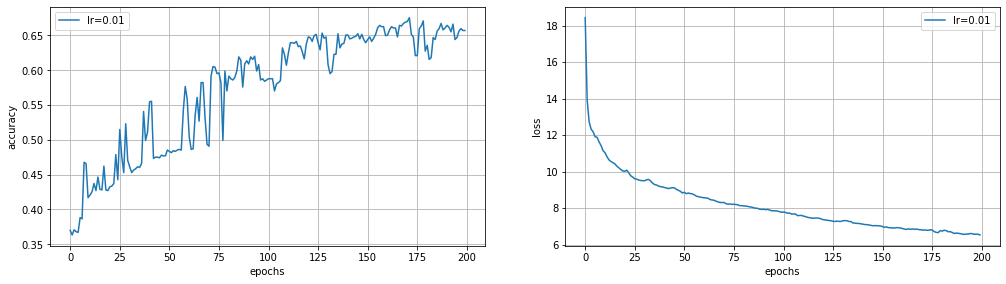

In [19]:
# passing dictionary but running with both users no partial
from IPython.core.pylabtools import figsize
# results with range(args.num_users)
import matplotlib.pyplot as plt
figures, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,5))
figures.tight_layout(pad = 5)
axes[0].plot(train_accuracy,label='lr='+str(args.lr))
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid()
axes[1].plot(train_loss,label='lr='+str(args.lr))
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()
axes[1].grid()
filename = 'synthetic_1_1_safereg'+args.optimizer+'_'+str(args.partial_users)+'of'+str(args.num_users)
figures.savefig(filename)

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
...
plt.subplot(1, 2, 2)

In [21]:
import pandas as pd

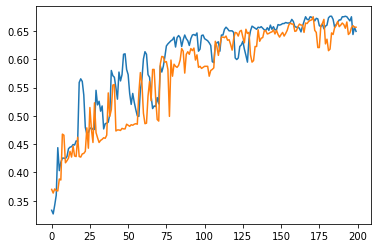

In [22]:
no_aa = pd.read_csv('Results/synthetic_1_1FedPD_10of30.csv', header=None)
plt.plot(no_aa.iloc[0])
plt.plot(train_accuracy)

In [ ]:
#save the output file as csv
import csv
with open(filename+'.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(train_accuracy) 
    write.writerow(train_loss)

In [ ]:
#load both FedPD and FedDR with same settings for comparison
import csv
train_acc_stored = []
with open('synthetic_05_05FedDR_10of30'+'.csv', 'r') as f:
  data = csv.reader(f)
  for row in data:
    train_acc_stored.append(row)
train_loss_stored = train_acc_stored.pop()
train_acc_stored_1 = [float(train_acc_stored[0][i]) for i in range(200)]
train_loss_stored_1 = [float(train_loss_stored[i]) for i in range(200)]

train_acc_stored = []
with open('synthetic_05_05FedPD_10of30'+'.csv', 'r') as f:
  data = csv.reader(f)
  for row in data:
    train_acc_stored.append(row)
train_loss_stored = train_acc_stored.pop()
train_acc_stored_2 = [float(train_acc_stored[0][i]) for i in range(200)]
train_loss_stored_2 = [float(train_loss_stored[i]) for i in range(200)]

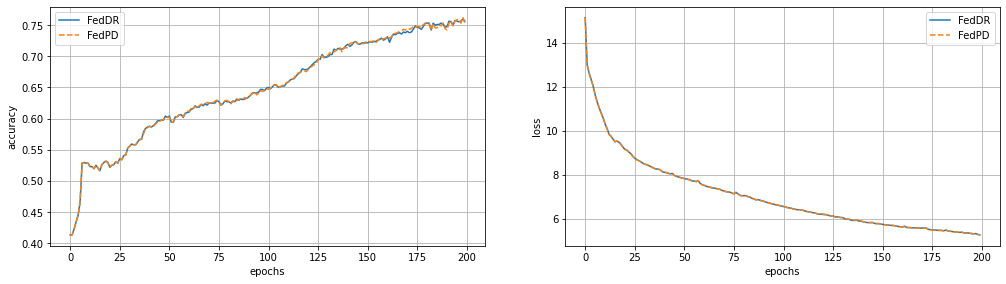

In [ ]:
from IPython.core.pylabtools import figsize
# results with range(args.num_users)
import matplotlib.pyplot as plt
figures, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,5))
figures.tight_layout(pad = 5)
axes[0].plot(train_acc_stored_1, label='FedDR')
axes[0].plot(train_acc_stored_2,linestyle = 'dashed',label='FedPD')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid()
axes[1].plot(train_loss_stored_1, label='FedDR')
axes[1].plot(train_loss_stored_2,linestyle = 'dashed', label='FedPD')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()
axes[1].grid()